### Installing Dependencies

In [1]:
!pip3 install webcolors
!pip3 install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 2.2 MB/s eta 0:00:00


### Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/Colab_Notebooks/EfficientDet/EfficientDet/efficientDet_pytorch'

In [4]:
!cp -rf /content/drive/MyDrive/Colab_Notebooks/EfficientDet/EfficientDet/efficientDet_pytorch efficientDet_pytorch

In [5]:
cd efficientDet_pytorch

/content/efficientDet_pytorch


In [11]:
ls

 backbone.py    datasets/                    ' logs'/        utils/
 benchmark/     efficientdet/                 logs/
 ckpt/          efficientnet/                 projects/
 coco_eval.py   effiecientDet_pytorch.ipynb   __pycache__/


### Importing Libraries

In [6]:
import time
import torch
from torch.backends import cudnn
from matplotlib import colors
import matplotlib.pyplot as plt
from PIL import Image


from backbone import EfficientDetBackbone
import cv2
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
import datetime
import os
import traceback

import torch
import yaml
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from backbone import EfficientDetBackbone
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from efficientdet.dataset import CocoDataset, Resizer, Normalizer, Augmenter, collater
from utils.utils import preprocess, invert_affine, postprocess, STANDARD_COLORS, standard_to_bgr, get_index_label, plot_one_box
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string

<ipython-input-6-8a900eaa799c>:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Defining Variables

In [7]:
pre_trained_model= 'ckpt'
dataset_path= 'datasets/coco'
num_gpus = 0#1
batch_size = 12
num_workers = 12
data_path = dataset_path
compound_coef = 0
load_weights = pre_trained_model+'/efficientdet-d0.pth'
head_only = True # to only train last layer of effiecientDet. set False if entire network is tobe trained
debug = False # 'whether visualize the predicted boxes of training,the output images will be in test/'
optim = 'adamw'
lr = 1e-04
num_epochs = 1# default = 500
saved_path =' logs/' + f'/coco/'
log_path = 'logs/' + f'/coco/tensorboard/'
os.makedirs(log_path, exist_ok=True)
os.makedirs(saved_path, exist_ok=True)

### Downloading Pre_trained Model

In [8]:
if os.path.exists(pre_trained_model) is False:
  print("Downloading pretrained Model")
  os.makedirs(pre_trained_model, exist_ok=True)
  !wget https://github.com/zylo117/Yet-Another-Efficient-Pytorch/releases/download/1.0/efficientdet-d0.pth -O ckpt/efficientdet-d0.pth
else:
  print('Already Downloaded')

Already Downloaded


### Downloading MSCOCO Dataset , Size = 26GB

drive/  sample_data/


In [12]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O datasets/coco/annotations_trainval2017.zip
# !unzip datasets/coco/annotations_trainval2017.zip -d datasets/coco

--2023-08-06 07:25:13--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.112.115, 52.216.58.105, 3.5.9.197, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.112.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘datasets/coco/annotations_trainval2017.zip’

datasets/coco/annot 100%[===================>] 241.19M  13.6MB/s    in 19s     

2023-08-06 07:25:33 (12.4 MB/s) - ‘datasets/coco/annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  datasets/coco/annotations_trainval2017.zip
replace datasets/coco/annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: datasets/coco/annotations/instances_train2017.json  a

replace datasets/coco/annotations/instances_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [a]
replace datasets/coc

In [9]:
if os.path.exists(dataset_path) is False:
  print("Downloading Data")
  os.makedirs(dataset_path, exist_ok=True)

  #Uncomment to download and extract train data (Needed only for training)

  !wget  http://images.cocodataset.org/zips/val2017.zip -O datasets/coco/val2017.zip
  #!wget  http://images.cocodataset.org/zips/train2017.zip -O datasets/coco/train2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O datasets/coco/annotations_trainval2017.zip


  !unzip datasets/coco/val2017.zip -d datasets/coco
  #!unzip train2017.zip -d datasets/coco
  !unzip datasets/coco/annotations_trainval2017.zip -d datasets/coco


else:
    print('Data already Downloaded')


Data already Downloaded


### Training

In [10]:
ls

 backbone.py    datasets/                    ' logs'/        utils/
 benchmark/     efficientdet/                 logs/
 ckpt/          efficientnet/                 projects/
 coco_eval.py   effiecientDet_pytorch.ipynb   __pycache__/


## 아래코드는 코코데이터셋 train이있어야함

In [11]:
class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)

params = Params(f'projects/coco.yml')


class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss




if num_gpus == 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)



training_params = {'batch_size': batch_size,
                   'shuffle': True,
                   'drop_last': True,
                   'collate_fn': collater,
                   'num_workers': num_workers}

val_params = {'batch_size': batch_size,
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
              'num_workers': num_workers}

input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
training_set = CocoDataset(root_dir=data_path, set=params.train_set,
                           transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                         Augmenter(),
                                                         Resizer(input_sizes[compound_coef])]))
print("training set = ",training_set)
print("path name = ",os.path.join(data_path, params.project_name))
training_generator = DataLoader(training_set, **training_params)

val_set = CocoDataset(root_dir=data_path, set=params.val_set,
                      transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                    Resizer(input_sizes[compound_coef])]))
val_generator = DataLoader(val_set, **val_params)

model = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=compound_coef,
                             ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

# load last weights
if load_weights is not None:
    if load_weights.endswith('.pth'):
        weights_path = load_weights
    else:
        weights_path = get_last_weights(saved_path)
    try:
        last_step = int(os.path.basename(weights_path).split('_')[-1].split('.')[0])
    except:
        last_step = 0

    try:
        ret = model.load_state_dict(torch.load(weights_path), strict=False)
    except RuntimeError as e:
        print(f'[Warning] Ignoring {e}')
        print(
            '[Warning] Don\'t panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.')

    print(f'[Info] loaded weights: {os.path.basename(weights_path)}, resuming checkpoint from step: {last_step}')
else:
    last_step = 0
    print('[Info] initializing weights...')
    init_weights(model)

# freeze backbone if train head_only
if head_only:
    def freeze_backbone(m):
        classname = m.__class__.__name__
        for ntl in ['EfficientNet', 'BiFPN']:
            if ntl in classname:
                for param in m.parameters():
                    param.requires_grad = False

    model.apply(freeze_backbone)
    print('[Info] freezed backbone')

# apply sync_bn when using multiple gpu and batch_size per gpu is lower than 4
#  useful when gpu memory is limited.
# because when bn is disable, the training will be very unstable or slow to converge,
# apply sync_bn can solve it,
# by packing all mini-batch across all gpus as one batch and normalize, then send it back to all gpus.
# but it would also slow down the training by a little bit.
if num_gpus > 1 and batch_size // num_gpus < 4:
    model.apply(replace_w_sync_bn)
    use_sync_bn = True
else:
    use_sync_bn = False

writer = SummaryWriter(log_path + f'/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/')

# warp the model with loss function, to reduce the memory usage on gpu0 and speedup
model = ModelWithLoss(model, debug=debug)

if num_gpus > 0:
    model = model.cuda()
    if num_gpus > 1:
        model = CustomDataParallel(model, num_gpus)
        if use_sync_bn:
            patch_replication_callback(model)

if optim == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

epoch = 0
best_loss = 1e5
best_epoch = 0
step = max(0, last_step)
model.train()

num_iter_per_epoch = len(training_generator)

try:
    for epoch in range(num_epochs):
        last_epoch = step // num_iter_per_epoch
        if epoch < last_epoch:
            continue

        epoch_loss = []
        progress_bar = tqdm(training_generator)
        for iter, data in enumerate(progress_bar):
            if iter < step - last_epoch * num_iter_per_epoch:
                progress_bar.update()
                continue
            try:
                imgs = data['img']
                annot = data['annot']

                if params.num_gpus == 1:
                    # if only one gpu, just send it to cuda:0
                    # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
                    imgs = imgs.cuda()
                    annot = annot.cuda()

                optimizer.zero_grad()
                cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
                cls_loss = cls_loss.mean()
                reg_loss = reg_loss.mean()

                loss = cls_loss + reg_loss
                if loss == 0 or not torch.isfinite(loss):
                    continue

                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                optimizer.step()

                epoch_loss.append(float(loss))

                progress_bar.set_description(
                    'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                        step, epoch, num_epochs, iter + 1, num_iter_per_epoch, cls_loss.item(),
                        reg_loss.item(), loss.item()))
                writer.add_scalars('Loss', {'train': loss}, step)
                writer.add_scalars('Regression_loss', {'train': reg_loss}, step)
                writer.add_scalars('Classfication_loss', {'train': cls_loss}, step)

                # log learning_rate
                current_lr = optimizer.param_groups[0]['lr']
                writer.add_scalar('learning_rate', current_lr, step)

                step += 1

                if step % opt.save_interval == 0 and step > 0:
                    save_checkpoint(model, f'efficientdet-d{compound_coef}_{epoch}_{step}.pth')
                    print('checkpoint...')

            except Exception as e:
                print('[Error]', traceback.format_exc())
                print(e)
                continue
        scheduler.step(np.mean(epoch_loss))

        if epoch % opt.val_interval == 0:
            model.eval()
            loss_regression_ls = []
            loss_classification_ls = []
            for iter, data in enumerate(val_generator):
                with torch.no_grad():
                    imgs = data['img']
                    annot = data['annot']

                    if params.num_gpus == 1:
                        imgs = imgs.cuda()
                        annot = annot.cuda()

                    cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
                    cls_loss = cls_loss.mean()
                    reg_loss = reg_loss.mean()

                    loss = cls_loss + reg_loss
                    if loss == 0 or not torch.isfinite(loss):
                        continue

                    loss_classification_ls.append(cls_loss.item())
                    loss_regression_ls.append(reg_loss.item())

            cls_loss = np.mean(loss_classification_ls)
            reg_loss = np.mean(loss_regression_ls)
            loss = cls_loss + reg_loss

            print(
                'Val. Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
                    epoch, num_epochs, cls_loss, reg_loss, loss))
            writer.add_scalars('Loss', {'val': loss}, step)
            writer.add_scalars('Regression_loss', {'val': reg_loss}, step)
            writer.add_scalars('Classfication_loss', {'val': cls_loss}, step)

            if loss + opt.es_min_delta < best_loss:
                best_loss = loss
                best_epoch = epoch

                save_checkpoint(model, f'efficientdet-d{compound_coef}_{epoch}_{step}.pth')

            model.train()

            # Early stopping

            if epoch - best_epoch > opt.es_patience > 0:
                print('[Info] Stop training at epoch {}. The lowest loss achieved is {}'.format(epoch, best_loss))
                break
except KeyboardInterrupt:
    save_checkpoint(model, f'efficientdet-d{compound_coef}_{epoch}_{step}.pth')
    writer.close()
writer.close()


def save_checkpoint(model, name):
    if isinstance(model, CustomDataParallel):
        torch.save(model.module.model.state_dict(), os.path.join(saved_path, name))
    else:
        torch.save(model.model.state_dict(), os.path.join(saved_path, name))
###########################
# error: Caught error in DataLoader worker process 0.
# Download training dataset by uncommetning training link  before starting training
############################

loading annotations into memory...
Done (t=16.83s)
creating index...
index created!
training set =  <efficientdet.dataset.CocoDataset object at 0x79ac1444a590>
path name =  datasets/coco/coco
loading annotations into memory...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Done (t=1.87s)
creating index...
index created!
[Info] loaded weights: efficientdet-d0.pth, resuming checkpoint from step: 0
[Info] freezed backbone


  0%|          | 0/9857 [00:00<?, ?it/s]

error: ignored

#  Inference

<ipython-input-13-79b68b8a3ae7>:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1, y1, x2, y2 = preds[i]['rois'][j].astype(np.int)


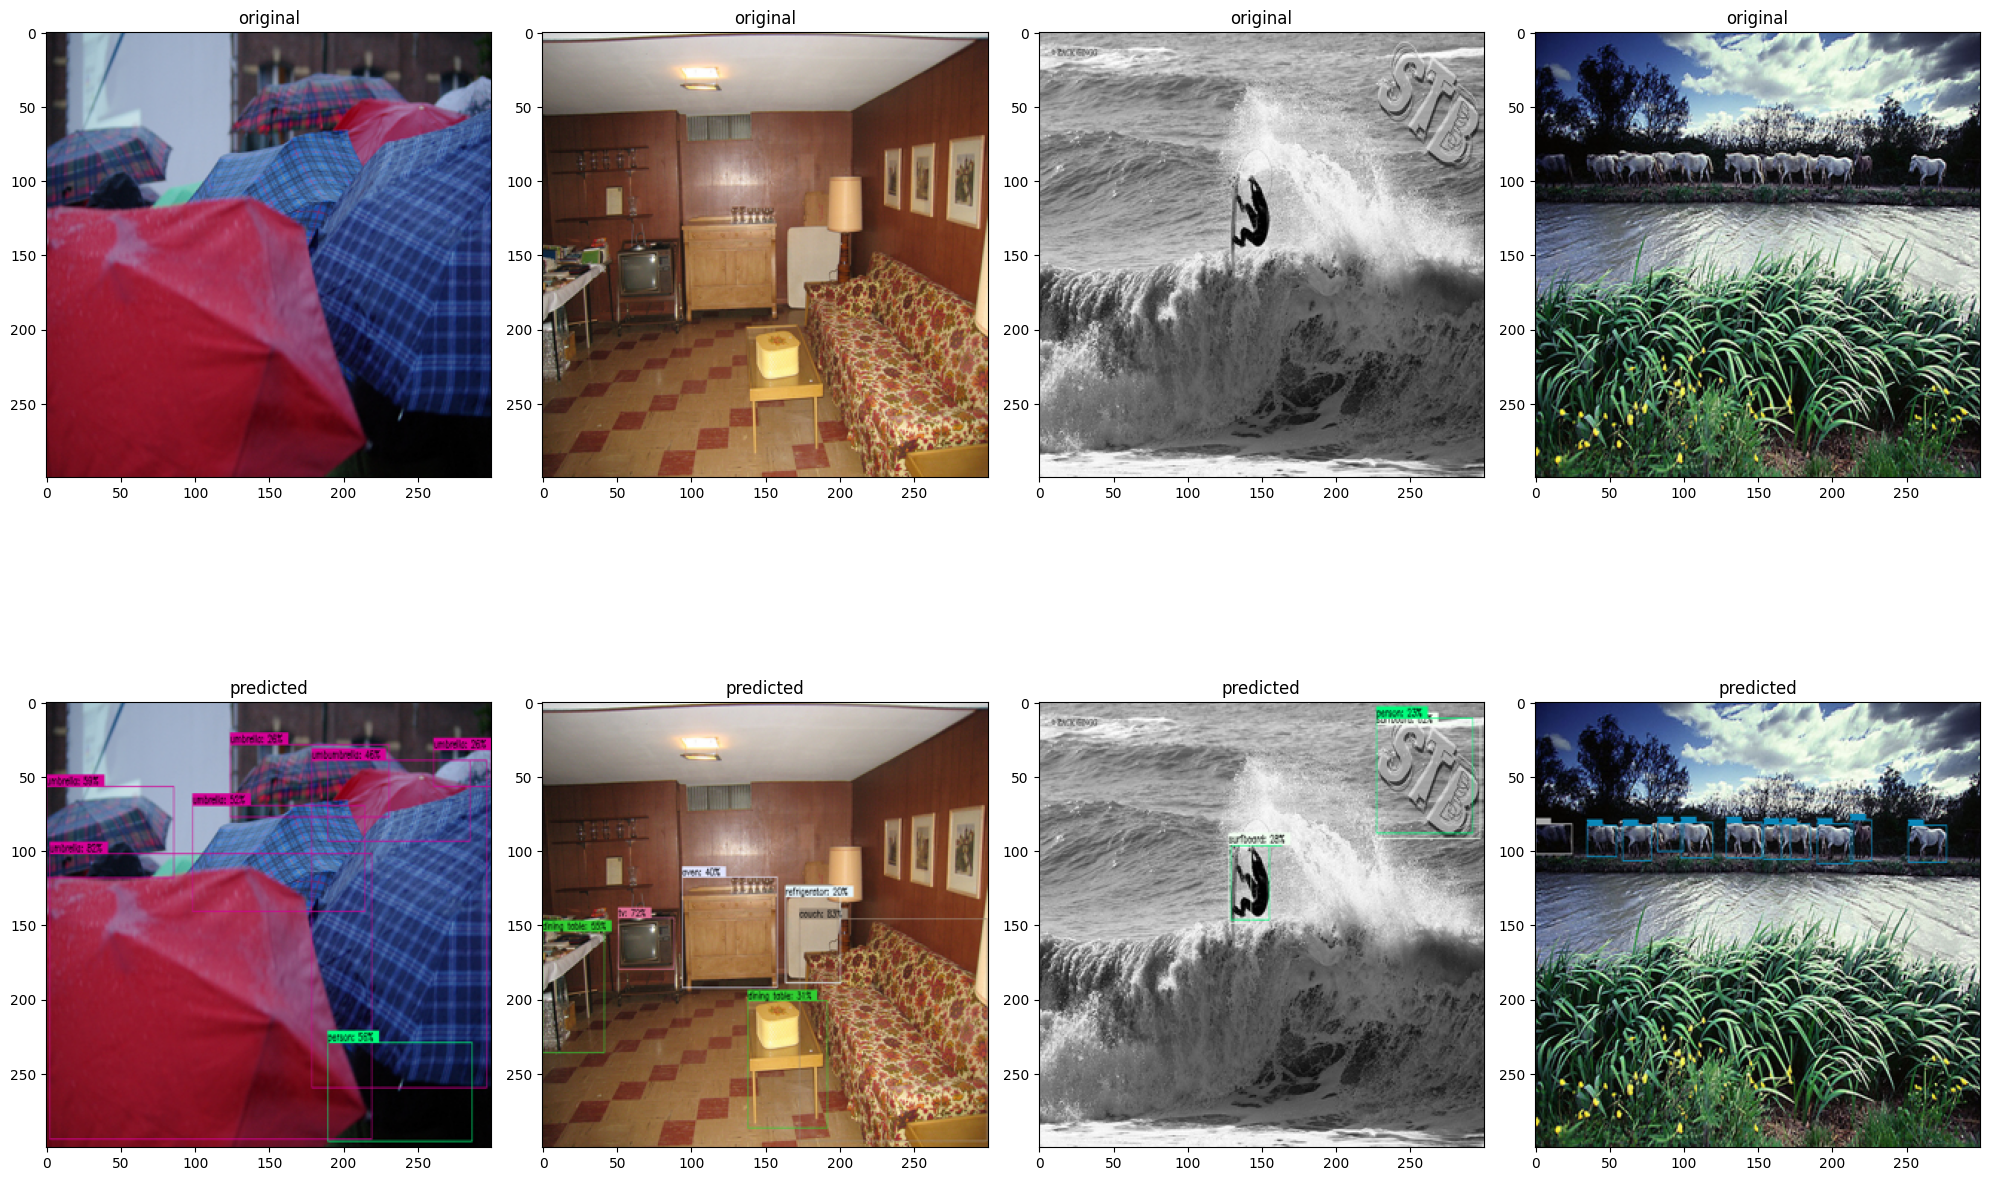

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(20,20))
compound_coef = 0
force_input_size = None  # set None to use default size
dir = os.listdir(dataset_path+'/val2017')
path_img=dir[0:4]

# replace this part with your project's anchor config
anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

threshold = 0.2
iou_threshold = 0.2

use_cuda = False
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
            'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush']

m=1
k=5
for l in path_img:


    color_list = standard_to_bgr(STANDARD_COLORS)
    input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
    input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
    ori_imgs, framed_imgs, framed_metas = preprocess(dataset_path+'/val2017'+'/'+l, max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                                ratios=anchor_ratios, scales=anchor_scales)
    model.load_state_dict(torch.load(load_weights, map_location='cpu'))
    model.requires_grad_(False)
    model.eval()

    if use_cuda:
        model = model.cuda()
    if use_float16:
        model = model.half()

    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)




    def display(preds, imgs, imshow=True, imwrite=False):
        for i in range(len(imgs)):
            if len(preds[i]['rois']) == 0:
                continue

            imgs[i] = imgs[i].copy()
            output_img= cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB)
            orig_img= cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB)


            for j in range(len(preds[i]['rois'])):
                x1, y1, x2, y2 = preds[i]['rois'][j].astype(np.int)
                obj = obj_list[preds[i]['class_ids'][j]]
                score = float(preds[i]['scores'][j])
                plot_one_box(output_img, [x1, y1, x2, y2], label=obj,score=score,color=color_list[get_index_label(obj, obj_list)])


            img_pred = Image.fromarray(output_img)
            orig_img = Image.fromarray(orig_img)
            img_pred=img_pred.resize((300,300))
            orig_img=orig_img.resize((300,300))
            plt.subplot(2,4,m)
            plt.imshow(orig_img)
            plt.title('original')
            plt.subplot(2,4,k)
            plt.imshow(img_pred)
            plt.title('predicted')




            if imwrite:
                cv2.imwrite(f'test/img_inferred_d{compound_coef}_this_repo_{i}.jpg', imgs[i])


    out = invert_affine(framed_metas, out)
    display(out, ori_imgs, imshow=False, imwrite=True)
    m=m+1
    k=k+1